```
NB: This is a 'testing' version of the exercise notebook. Differences from what will be the production notebook
- I've included (full, runnable) solution code
- I've set the notebook up to be runnable from top-to-bottom without exceptions (hence wrapping the starter code cells in "if 0:")
- A bit of extra debugging/experimental code (marked as such with TODO/XXX comments)
```

In [1]:
# Setup code. Make sure you run this first!

import os
import random
import math

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow import keras

data_dir = '../input/movielens_preprocessed'
# Load a 10% subset of the full MovieLens data.
df = pd.read_csv(os.path.join(data_dir, 'mini_rating.csv'))

print("Setup complete!")

Setup complete!


# Exercise (embeddings)

In this exercise, you'll add an enhancement to the embedding model from the previous lesson. To start, let's train a model with the same parameters so you have a baseline to compare against. **Run the cell below**. (It will take about 30 seconds, but you can start on part 1 while it runs.)

> *Aside*: Training the model in the tutorial took around a minute per epoch. To make training time more manageable, we'll be working with a sample of 10% of the total dataset (or around 2 million ratings). Therefore, we should expect our results to be generally worse than in the tutorial.

In [2]:
# TODO: A bit slow (around 30s, but maybe encourage them to start this cell running then jump ahead to
# question 1 - which has no coding.)
import time; t0 = time.time()

LR = .005
EPOCHS = 8
hidden_units = (32,4)
movie_embedding_size = 8
user_embedding_size = 8

# Training without bias

tf.set_random_seed(1); np.random.seed(1); random.seed(1)

user_id_input = keras.Input(shape=(1,), name='user_id')
movie_id_input = keras.Input(shape=(1,), name='movie_id')
user_embedded = keras.layers.Embedding(df.userId.max()+1, user_embedding_size, 
                                       input_length=1, name='user_embedding')(user_id_input)
movie_embedded = keras.layers.Embedding(df.movieId.max()+1, movie_embedding_size, 
                                        input_length=1, name='movie_embedding')(movie_id_input)
concatenated = keras.layers.Concatenate()([user_embedded, movie_embedded])
out = keras.layers.Flatten()(concatenated)

# Add one or more hidden layers
for n_hidden in hidden_units:
    out = keras.layers.Dense(n_hidden, activation='relu')(out)

# A single output: our predicted rating
out = keras.layers.Dense(1, activation='linear', name='prediction')(out)

base_model = keras.Model(
    inputs = [user_id_input, movie_id_input],
    outputs = out,
)
base_model.compile(
    tf.train.AdamOptimizer(LR),
    loss='MSE',
    metrics=['MAE'],
)
history = base_model.fit(
    [df.userId, df.movieId],
    df.y,
    batch_size=5 * 10**3,
    epochs=EPOCHS,
    verbose=0,
    validation_split=.05,
);
print("Finished in {:.1f}s".format(time.time()-t0))

Finished in 25.5s


## Adding biases

I propose an improvement to the model we trained in the tutorial: per-movie biases. In ML-speak, a **bias** is just a number that gets added to a node's output value. For each movie, we'll learn a single number that we'll add to the output of what was previously our final node. Here's what that looks like:

**TODO: diagram**

## Part 1: Why?

Do you think this will improve the accuracy of our predictions? Why or why not?

Think about it, then uncomment the line below to see an explanation.

In [3]:
#part1.a.solution()
"""
One basic observation is that adding biases gives our model more numbers to tune, and in this
sense it's strictly increasing its "capacity". This alone is a good enough reason to believe
adding biases will at least increase our accuracy on the training set (and possibly on the 
validation set, depending on how much we're already overfitting).

But we could also increase our model's capacity by just increasing the size of our embeddings, or
the number of hidden units. How does adding biases differ from that?
""";

Do you have an idea about what the bias values will look like? Are there certain movies you expect will have high or low biases?

In [4]:
#part1.b.solution()
"""
Some movies are, on average, rated significantly higher or lower than others. 
In the tutorial, I mentioned that predicting the average rating per-movie gave much
better results than always predicting the global average. Per-movie biases are a simple
way for our model to account for the relative goodness or badness of movies. 

If the model does utilize the biases in this way, then we should expect the highest biases
to go to highly acclaimed movies like *The Godfather* or *Schindler's List*, and the lowest
biases to go to stinkers like *Battlefield Earth* or *Sharknado*.

This relates to the question I posed above: how is adding biases to our model different from 
increasing its capacity by making the embedding vectors bigger or adding hidden units? Because 
our biases get added at the very end, our model has a lot less flexibility in how to use them. 
And this can be a good thing. At a high level, we're imposing a prior belief - that some movies
are intrinsically better or worse than others. This is a form of regularization!
""";

## Part 2: Coding it up

Below is the code we used to train our embedding model in the tutorial. Modify it (where indicated by the comments) to add per-movie biases.

In [5]:
if 0:
    user_id_input = keras.Input(shape=(1,), name='user_id')
    movie_id_input = keras.Input(shape=(1,), name='movie_id')
    user_embedded = keras.layers.Embedding(df.userId.max()+1, user_embedding_size, 
                                           input_length=1, name='user_embedding')(user_id_input)
    movie_embedded = keras.layers.Embedding(df.movieId.max()+1, movie_embedding_size, 
                                            input_length=1, name='movie_embedding')(movie_id_input)
    concatenated = keras.layers.Concatenate()([user_embedded, movie_embedded])
    out = keras.layers.Flatten()(concatenated)

    # Add one or more hidden layers
    for n_hidden in hidden_units:
        out = keras.layers.Dense(n_hidden, activation='relu')(out)

    # A single output: our predicted rating (before adding bias)
    out = keras.layers.Dense(1, activation='linear', name='prediction')(out)

    ################################################################################
    ############################# YOUR CODE GOES HERE! #############################
    # TODO: you need to create the variable movie_bias. Its value should be the output of calling a layer.
    #movie_bias = 
    ################################################################################
    out = keras.layers.Add()([out, movie_bias])

    model = keras.Model(
        inputs = [user_id_input, movie_id_input],
        outputs = out,
    )
    model.compile(
        tf.train.AdamOptimizer(LR),
        loss='MSE',
        metrics=['MAE'],
    )
    model.summary()

    part2.check()

No idea where to start? Don't panic! Uncomment and run the line below for some hints.

In [6]:
#q2.hint()
""" (multi-part hint)
1. Surprisingly, this is another use case for an embedding layer. Check out the docs 
on [keras.layers.Embedding](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding)
to review its parameters.
2. As with our existing use of Embedding layers, you may need to flatten its output to get rid of 
an extra dimension.
""";

In [7]:
#q2.solution()
tf.set_random_seed(1); np.random.seed(1); random.seed(1)

user_id_input = keras.Input(shape=(1,), name='user_id')
movie_id_input = keras.Input(shape=(1,), name='movie_id')
user_embedded = keras.layers.Embedding(df.userId.max()+1, user_embedding_size, 
                                       input_length=1, name='user_embedding')(user_id_input)
movie_embedded = keras.layers.Embedding(df.movieId.max()+1, movie_embedding_size, 
                                        input_length=1, name='movie_embedding')(movie_id_input)
concatenated = keras.layers.Concatenate()([user_embedded, movie_embedded])
out = keras.layers.Flatten()(concatenated)

# Add one or more hidden layers
for n_hidden in hidden_units:
    out = keras.layers.Dense(n_hidden, activation='relu')(out)

# A single output: our predicted rating
out = keras.layers.Dense(1, activation='linear', name='prediction')(out)

bias_embedded = keras.layers.Embedding(df.movieId.max()+1, 1, input_length=1, name='bias',
                                       embeddings_initializer='zeros', # XXX: experiment
                                      )(movie_id_input)
movie_bias = keras.layers.Flatten()(bias_embedded)
out = keras.layers.Add()([out, movie_bias])

model_bias = keras.Model(
    inputs = [user_id_input, movie_id_input],
    outputs = out,
)
model_bias.compile(
    tf.train.AdamOptimizer(LR),
    loss='MSE',
    metrics=['MAE'],
)

## Part 3: Training

Run the code below to train the model you built in the previous step.

In [8]:
history_bias = model_bias.fit(
    [df.userId, df.movieId],
    df.y,
    batch_size=5 * 10**3,
    epochs=EPOCHS,
    verbose=2,
    validation_split=.05,
);

Train on 1900000 samples, validate on 100000 samples
Epoch 1/8
 - 3s - loss: 0.8570 - mean_absolute_error: 0.7190 - val_loss: 0.7544 - val_mean_absolute_error: 0.6682
Epoch 2/8
 - 3s - loss: 0.7273 - mean_absolute_error: 0.6562 - val_loss: 0.7334 - val_mean_absolute_error: 0.6574
Epoch 3/8
 - 3s - loss: 0.7034 - mean_absolute_error: 0.6437 - val_loss: 0.7168 - val_mean_absolute_error: 0.6522
Epoch 4/8
 - 3s - loss: 0.6861 - mean_absolute_error: 0.6351 - val_loss: 0.7077 - val_mean_absolute_error: 0.6468
Epoch 5/8
 - 3s - loss: 0.6745 - mean_absolute_error: 0.6295 - val_loss: 0.7033 - val_mean_absolute_error: 0.6420
Epoch 6/8
 - 3s - loss: 0.6656 - mean_absolute_error: 0.6253 - val_loss: 0.7018 - val_mean_absolute_error: 0.6417
Epoch 7/8
 - 3s - loss: 0.6582 - mean_absolute_error: 0.6216 - val_loss: 0.7018 - val_mean_absolute_error: 0.6407
Epoch 8/8
 - 3s - loss: 0.6512 - mean_absolute_error: 0.6183 - val_loss: 0.6993 - val_mean_absolute_error: 0.6408


How does it compare to the results we got from the model without biases? Run the code cell below to compare their loss over the course of training.

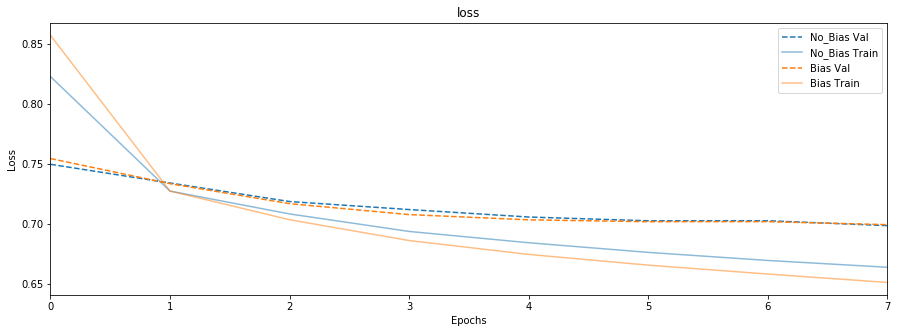

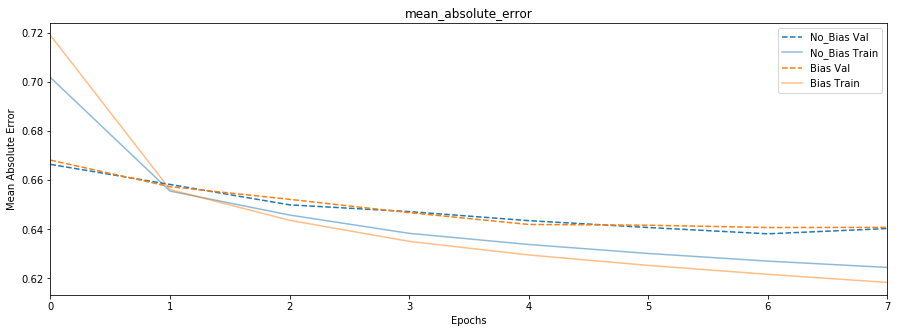

In [9]:
history_FS = (15, 5)
def plot_history(histories, keys=('loss', 'mean_absolute_error'), train=True, figsize=history_FS):
    if isinstance(histories, tf.keras.callbacks.History):
        histories = [ ('', histories) ]
    for key in keys:
        plt.figure(figsize=history_FS)
        for name, history in histories:
            val = plt.plot(history.epoch, history.history['val_'+key],
                           '--', label=str(name).title()+' Val')
            if train:
                plt.plot(history.epoch, history.history[key], color=val[0].get_color(), alpha=.5,
                         label=str(name).title()+' Train')

        plt.xlabel('Epochs')
        plt.ylabel(key.replace('_',' ').title())
        plt.legend()
        plt.title(key)

        plt.xlim([0,max(max(history.epoch) for (_, history) in histories)])
        #plt.ylim(top=0.8)

plot_history([ 
    ('no_bias', history),
    ('bias', history_bias),
]);

How did adding biases affect our results?

Averaged over many runs, biases seem to help a bit, but there's enough variance between runs (as a result of different random initializations), that you might be seeing better or worse results. If you're seeing a *big* difference (more than, say, +-.02 in the final loss) in either direction, something may have gone wrong.

So biases weren't the huge win we might have hoped for, but it still seems worth testing our hypothesis about how bias values will be distributed among movies.

## Part 4: Exploring bias values

Run the cell below to load the bias values learned by the model and add them to a dataframe containing movie metadata.

In [10]:
bias_layer = model_bias.get_layer('bias')
(b,) = bias_layer.get_weights()
print("Loaded biases with shape {}".format(b.shape))

movies = pd.read_csv(os.path.join(data_dir, 'movie.csv'), index_col=0, 
                     usecols=['movieId', 'title', 'genres', 'year'])
ntrain = math.floor(len(df) * .95)
df_train = df.head(ntrain)

# Mapping from original movie ids to canonical ones
mids = movieId_to_canon = df.groupby('movieId')['movieId_orig'].first()
# Add bias column
movies.loc[mids.values, 'bias'] = b
# Add columns for number of ratings and average rating
g = df_train.groupby('movieId_orig')
movies.loc[mids.values, 'n_ratings'] = g.size()
movies.loc[mids.values, 'mean_rating'] = g['rating'].mean()

movies.head()

Loaded biases with shape (16715, 1)


,title,genres,year,bias,n_ratings,mean_rating
movieId,,,,,,
0,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995,0.445248,4631.0,3.931656
1,Jumanji,Adventure|Children|Fantasy,1995,-0.132889,2097.0,3.221984
2,Grumpier Old Men,Comedy|Romance,1995,-0.266421,1202.0,3.155158
3,Waiting to Exhale,Comedy|Drama|Romance,1995,-0.427077,261.0,2.955939
4,Father of the Bride Part II,Comedy,1995,-0.388709,1175.0,3.089362


Which movies have the lowest and highest learned biases? Run the cell below to find out.

In [11]:
from IPython.display import display
n = 10
display(
    "Largest biases...",
    movies.sort_values(by='bias', ascending=False).head(n),
    "Smallest biases...",
    movies.sort_values(by='bias').head(n),
)

'Largest biases...'

,title,genres,year,bias,n_ratings,mean_rating
movieId,,,,,,
13421,Singapore Sling (Singapore sling: O anthropos ...,Crime|Film-Noir|Horror|Romance|Thriller,1990,0.921055,3.0,4.833333
14073,Abandon Ship! (Seven Waves Away),Adventure|Drama,1957,0.893147,2.0,3.750000
13262,Zona Zamfirova,Comedy|Drama,2002,0.883634,2.0,4.250000
20520,Oh Boy (A Coffee in Berlin),Comedy|Drama,2012,0.869518,3.0,4.333333
12895,Absolute Giganten,Action|Comedy|Drama|Romance,1999,0.806772,2.0,5.000000
13260,Constantine's Sword,Documentary,2007,0.798806,2.0,4.250000
23372,Raze,Action|Horror,2013,0.781753,2.0,4.750000
22967,Starred Up,Drama,2013,0.781235,5.0,3.900000
14857,$9.99,Animation,2008,0.766355,2.0,4.250000


'Smallest biases...'

,title,genres,year,bias,n_ratings,mean_rating
movieId,,,,,,
1489,The Second Jungle Book: Mowgli & Baloo,Adventure|Children,1997,-1.128563,13.0,1.653846
5404,The Master of Disguise,Comedy|Mystery,2002,-1.028470,70.0,1.821429
8176,SuperBabies: Baby Geniuses 2,Comedy,2004,-0.990663,20.0,0.625000
4147,Pokémon 3: The Movie,Animation|Children,2001,-0.975653,51.0,1.078431
16652,Home Alone 4,Children|Comedy|Crime,2002,-0.949680,20.0,1.425000
13259,War of the Worlds 2: The Next Wave,Action,2008,-0.936058,4.0,0.875000
12392,Meet the Spartans,Comedy,2008,-0.926874,58.0,1.482759
8649,Manos: The Hands of Fate,Horror,1966,-0.923148,2.0,0.500000
10885,Leprechaun 2,Comedy|Fantasy|Horror,1994,-0.918577,6.0,2.000000


Run the cell below to generate a scatter plot of movies' average ratings against the biases learned for those movies.

(You may see some vertical 'stripe' patterns. Can you guess why?)

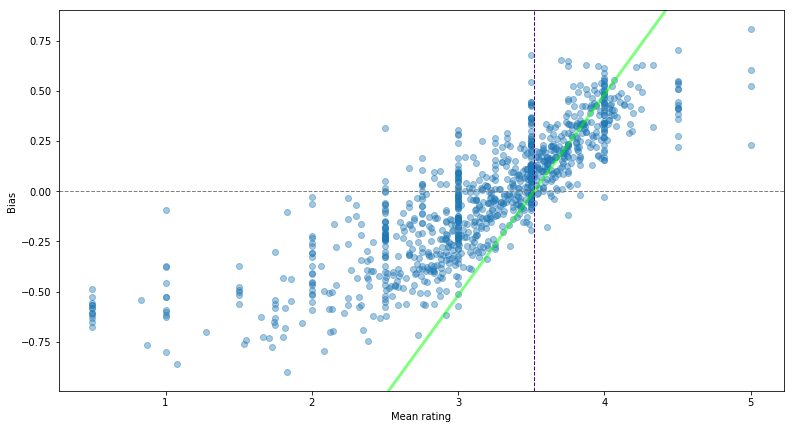

In [12]:
n = 1000
mini = movies[movies.n_ratings >= 0].sample(n, random_state=1)

fig, ax = plt.subplots(figsize=(13, 7))
ax.scatter(mini['mean_rating'], mini['bias'], alpha=.4)

# XXX: Paragraph below is all experimentation/debugging. Should be removed later.
row = df.iloc[0]
global_mean_rating = row.rating - row.y
lw = 1
ax.axhline(0, ls='--', color='grey', lw=lw)
ax.axvline(global_mean_rating, ls='--', label='Overall mean rating', color='indigo', lw=lw)
# Draw line of expected fit (if biases were to match data means)
pt = (global_mean_rating, 0)
x0, y0 = 0.5, (0.5 - global_mean_rating)
x1, y1 = 5, (5 - global_mean_rating)
ylim0 = ax.get_ylim()
ax.plot([x0, x1], [y0, y1], linestyle='-', lw=3, color='lime', alpha=.5)
ax.set_ylim(ylim0)

ax.set_xlabel('Mean rating')
ax.set_ylabel('Bias');

Considering this plot and the list of our highest and lowest bias movies, do you think our learned biases are reasonable? Why or why not?

In [13]:
#part_4.solution()
"""
Directionally, these biases make sense. Highly rated movies have high biases, and poorly rated movies
have low biases. This agrees with the intuition discussed earlier about biases corresponding to goodness/badness.

But a problem sticks out. We're naively assigning biases which are approximately proportional to movies' 
average ratings - even for movies with few reviews. I'm not convinced that *Gray Lady Down* is the worst
movie ever based on *one* bad review. 

If you're shopping for a can opener, would you rather buy the one with a single 5-star review, or the one
with an average rating of 4.95 over 3,000 reviews? 

This is an especially important problem when dealing with sparse categorical data which can often have long tails
of rare values. We'll talk about an elegant solution to this problem - L2 regularization - in the next lesson.
""";

## Part 5: User biases

It turns out that users have a much less spiky distribution in the dataset (by construction - the MovieLens dataset only included users who gave at least 20 ratings). For this reason, adding per-*user* biases tends to have a more consistently positive effect on accuracy.

Run the cell below to train a model with per-user biases, and compare the results with our earlier models.

Train on 1900000 samples, validate on 100000 samples
Epoch 1/8
 - 4s - loss: 0.8374 - mean_absolute_error: 0.7091 - val_loss: 0.7459 - val_mean_absolute_error: 0.6620
Epoch 2/8
 - 5s - loss: 0.7177 - mean_absolute_error: 0.6502 - val_loss: 0.7248 - val_mean_absolute_error: 0.6518
Epoch 3/8
 - 3s - loss: 0.6981 - mean_absolute_error: 0.6406 - val_loss: 0.7149 - val_mean_absolute_error: 0.6497
Epoch 4/8
 - 3s - loss: 0.6861 - mean_absolute_error: 0.6348 - val_loss: 0.7086 - val_mean_absolute_error: 0.6460
Epoch 5/8
 - 4s - loss: 0.6757 - mean_absolute_error: 0.6298 - val_loss: 0.7032 - val_mean_absolute_error: 0.6401
Epoch 6/8
 - 4s - loss: 0.6653 - mean_absolute_error: 0.6248 - val_loss: 0.6995 - val_mean_absolute_error: 0.6397
Epoch 7/8
 - 3s - loss: 0.6556 - mean_absolute_error: 0.6199 - val_loss: 0.6960 - val_mean_absolute_error: 0.6381
Epoch 8/8
 - 3s - loss: 0.6470 - mean_absolute_error: 0.6157 - val_loss: 0.6956 - val_mean_absolute_error: 0.6371


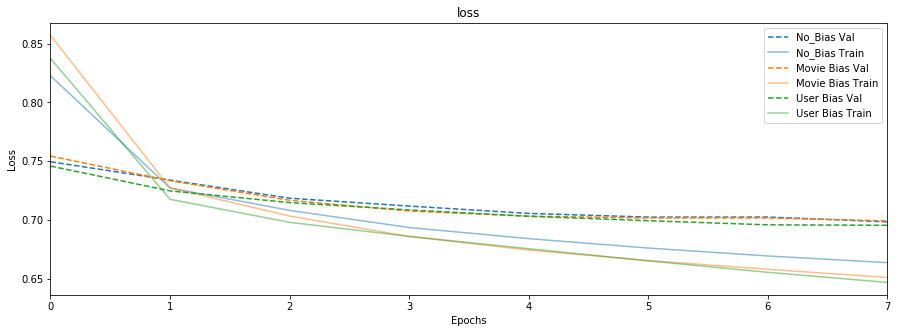

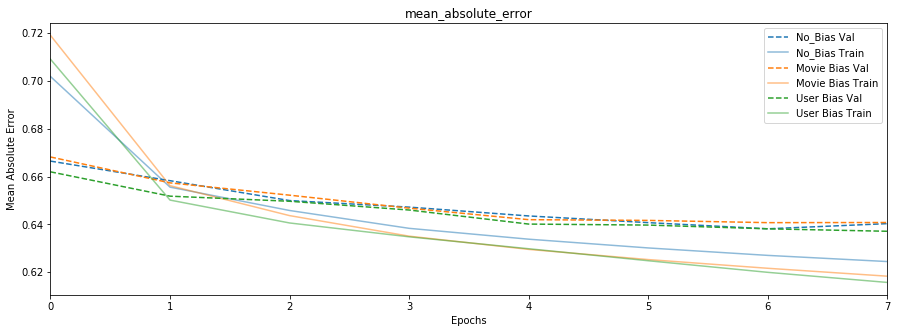

In [14]:
tf.set_random_seed(1); np.random.seed(1); random.seed(1)

user_id_input = keras.Input(shape=(1,), name='user_id')
movie_id_input = keras.Input(shape=(1,), name='movie_id')
user_embedded = keras.layers.Embedding(df.userId.max()+1, user_embedding_size, 
                                       input_length=1, name='user_embedding')(user_id_input)
movie_embedded = keras.layers.Embedding(df.movieId.max()+1, movie_embedding_size, 
                                        input_length=1, name='movie_embedding')(movie_id_input)
concatenated = keras.layers.Concatenate()([user_embedded, movie_embedded])
out = keras.layers.Flatten()(concatenated)

# Add one or more hidden layers
for n_hidden in hidden_units:
    out = keras.layers.Dense(n_hidden, activation='relu')(out)

# A single output: our predicted rating
out = keras.layers.Dense(1, activation='linear', name='prediction')(out)

bias_embedded = keras.layers.Embedding(df.userId.max()+1, 1, input_length=1, name='bias',
                                       embeddings_initializer='zeros', # XXX: experiment
                                      )(user_id_input)
user_bias = keras.layers.Flatten()(bias_embedded)
out = keras.layers.Add()([out, user_bias])

model = keras.Model(
    inputs = [user_id_input, movie_id_input],
    outputs = out,
)
model.compile(
    tf.train.AdamOptimizer(LR),
    loss='MSE',
    metrics=['MAE'],
)

history_ubias = model.fit(
    [df.userId, df.movieId],
    df.y,
    batch_size=5 * 10**3,
    epochs=EPOCHS,
    verbose=2,
    validation_split=.05,
);
plot_history([ 
    ('no_bias', history),
    ('movie bias', history_bias),
    ('user bias', history_ubias),
]);

In [19]:
####################################
########### SCRATCH BELOW ##########
####################################
assert False

AssertionError: 

In [ ]:
# Experiment: predictions before any training

tf.set_random_seed(1); np.random.seed(1); random.seed(1)

user_id_input = keras.Input(shape=(1,), name='user_id')
movie_id_input = keras.Input(shape=(1,), name='movie_id')
user_embedded = keras.layers.Embedding(df.userId.max()+1, user_embedding_size, 
                                       input_length=1, name='user_embedding')(user_id_input)
movie_embedded = keras.layers.Embedding(df.movieId.max()+1, movie_embedding_size, 
                                        input_length=1, name='movie_embedding')(movie_id_input)
concatenated = keras.layers.Concatenate()([user_embedded, movie_embedded])
out = keras.layers.Flatten()(concatenated)

# Add one or more hidden layers
for n_hidden in hidden_units:
    out = keras.layers.Dense(n_hidden, activation='relu')(out)

# A single output: our predicted rating
out = keras.layers.Dense(1, activation='linear', name='prediction')(out)

bias_embedded = keras.layers.Embedding(df.movieId.max()+1, 1, input_length=1, name='bias',
                                       embeddings_initializer='zeros', # XXX: experiment
                                      )(movie_id_input)
movie_bias = keras.layers.Flatten()(bias_embedded)
out = keras.layers.Add()([out, movie_bias])

model_bias = keras.Model(
    inputs = [user_id_input, movie_id_input],
    outputs = out,
)
model_bias.compile(
    tf.train.AdamOptimizer(LR),
    loss='MSE',
    metrics=['MAE'],
)

z = df.tail(5000)
preds = model_bias.predict([z.userId, z.movieId]).flatten()
s = pd.Series(preds)
s.describe()

In [ ]:
s.plot.hist(figsize=(14, 7), bins=50);

In [ ]:
n = 1000
mini = movies[movies.n_ratings >= 0].sample(n, random_state=1)

fig, ax = plt.subplots(figsize=(13, 7))
ax.scatter(mini['mean_rating'], mini['bias'], alpha=.4)

row = df.iloc[0]
global_mean_rating = row.rating - row.y
lw = 1
ax.axhline(0, ls='--', color='grey', lw=lw)
ax.axvline(global_mean_rating, ls='--', label='Overall mean rating', color='indigo', lw=lw)
# Draw line of expected fit (if biases were to match data means)
pt = (global_mean_rating, 0)
x0, y0 = 0.5, (0.5 - global_mean_rating)
x1, y1 = 5, (5 - global_mean_rating)
ylim0 = ax.get_ylim()
ax.plot([x0, x1], [y0, y1], linestyle='-', lw=3, color='lime', alpha=.5)
ax.set_ylim(ylim0)

ax.set_xlabel('Mean rating')
ax.set_ylabel('Bias');

RIP this question:

## Part 6: (BONUS) Smart bias initialization

In part 5, we saw that our model naturally learns bias values that are very strongly correlated with the average rating of the corresponding movie (or, presumably, user, in the case of user biases).

What if we give our model a headstart by setting the biases to the data means before we even run a single iteration of training?

Fill in the missing code below to achieve this.

(cite Hinton paper)

In [15]:
if 0:
    tf.set_random_seed(1); np.random.seed(1); random.seed(1)

    user_id_input = keras.Input(shape=(1,), name='user_id')
    movie_id_input = keras.Input(shape=(1,), name='movie_id')
    user_embedded = keras.layers.Embedding(df.userId.max()+1, user_embedding_size, 
                                           input_length=1, name='user_embedding')(user_id_input)
    movie_embedded = keras.layers.Embedding(df.movieId.max()+1, movie_embedding_size, 
                                            input_length=1, name='movie_embedding')(movie_id_input)
    concatenated = keras.layers.Concatenate()([user_embedded, movie_embedded])
    out = keras.layers.Flatten()(concatenated)

    # Add one or more hidden layers
    for n_hidden in hidden_units:
        out = keras.layers.Dense(n_hidden, activation='relu')(out)

    # A single output: our predicted rating
    out = keras.layers.Dense(1, activation='linear', name='prediction')(out)


    # NB: Calling model.fit with validation_split=.05 will take the final 5% of the data
    # as the validation set, and the rest as the training set.
    ntrain = math.floor(len(df) * .95)
    df_train = df.head(ntrain)
    # Pandas Series mapping user ids to their average rating
    mean_per_user = df_train.groupby('userId')['y'].mean()
    ################################################################################
    ############################# YOUR CODE GOES HERE! #############################
    # TODO: b_init should be an initializer object (https://www.tensorflow.org/api_docs/python/tf/keras/initializers)
    # which initializes the bias for each user to the average value of the target variable ('y') for that user.
    b_init = None
    ################################################################################

    bias_embedded = keras.layers.Embedding(df.userId.max()+1, 1, input_length=1, name='bias',
                                           embeddings_initializer=b_init,
                                          )(user_id_input)

    movie_bias = keras.layers.Flatten()(bias_embedded)
    out = keras.layers.Add()([out, movie_bias])

    model = keras.Model(
        inputs = [user_id_input, movie_id_input],
        outputs = out,
    )
    model.compile(
        tf.train.AdamOptimizer(LR),
        loss='MSE',
        metrics=['MAE'],
    )

    history_ubias_hs = model.fit(
        [df.userId, df.movieId],
        df.y,
        batch_size=5 * 10**3,
        epochs=EPOCHS,
        verbose=2,
        validation_split=.05,
    );

Uncomment the cell below for the solution.

Train on 1900000 samples, validate on 100000 samples
Epoch 1/8
 - 4s - loss: 0.8251 - mean_absolute_error: 0.7004 - val_loss: 0.7625 - val_mean_absolute_error: 0.6699
Epoch 2/8
 - 3s - loss: 0.7232 - mean_absolute_error: 0.6521 - val_loss: 0.7283 - val_mean_absolute_error: 0.6539
Epoch 3/8
 - 3s - loss: 0.6963 - mean_absolute_error: 0.6397 - val_loss: 0.7160 - val_mean_absolute_error: 0.6511
Epoch 4/8
 - 4s - loss: 0.6805 - mean_absolute_error: 0.6323 - val_loss: 0.7066 - val_mean_absolute_error: 0.6426
Epoch 5/8
 - 3s - loss: 0.6674 - mean_absolute_error: 0.6259 - val_loss: 0.7001 - val_mean_absolute_error: 0.6398
Epoch 6/8
 - 3s - loss: 0.6560 - mean_absolute_error: 0.6204 - val_loss: 0.6978 - val_mean_absolute_error: 0.6395
Epoch 7/8
 - 3s - loss: 0.6473 - mean_absolute_error: 0.6160 - val_loss: 0.6981 - val_mean_absolute_error: 0.6381
Epoch 8/8
 - 4s - loss: 0.6403 - mean_absolute_error: 0.6125 - val_loss: 0.6974 - val_mean_absolute_error: 0.6387


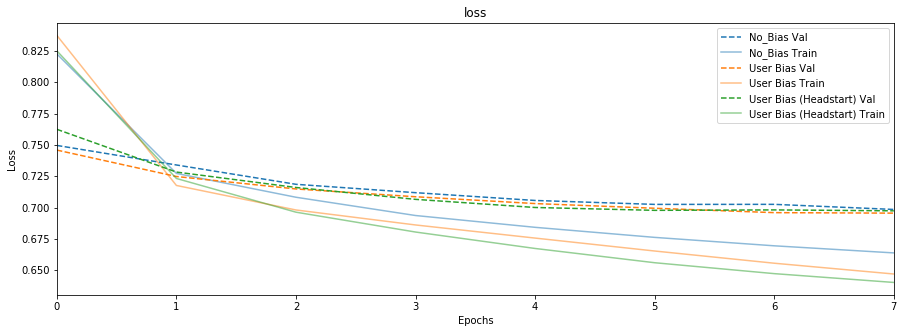

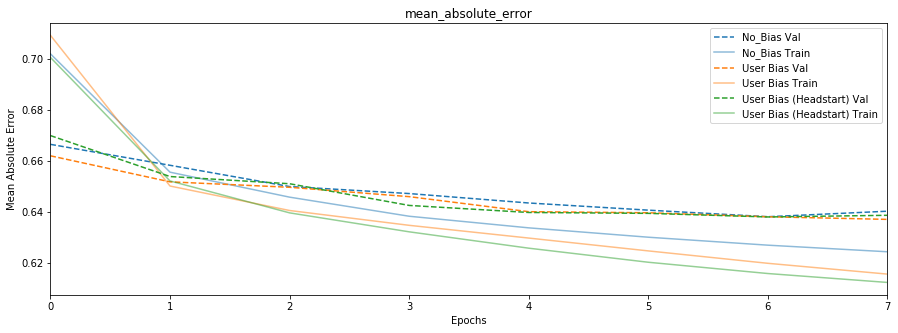

In [16]:
# Full solution (for testing)
tf.set_random_seed(1); np.random.seed(1); random.seed(1)

user_id_input = keras.Input(shape=(1,), name='user_id')
movie_id_input = keras.Input(shape=(1,), name='movie_id')
user_embedded = keras.layers.Embedding(df.userId.max()+1, user_embedding_size, 
                                       input_length=1, name='user_embedding')(user_id_input)
movie_embedded = keras.layers.Embedding(df.movieId.max()+1, movie_embedding_size, 
                                        input_length=1, name='movie_embedding')(movie_id_input)
concatenated = keras.layers.Concatenate()([user_embedded, movie_embedded])
out = keras.layers.Flatten()(concatenated)

# Add one or more hidden layers
for n_hidden in hidden_units:
    out = keras.layers.Dense(n_hidden, activation='relu')(out)

# A single output: our predicted rating
out = keras.layers.Dense(1, activation='linear', name='prediction')(out)


# NB: Calling model.fit with validation_split=.05 will take the final 5% of the data
# as the validation set, and the rest as the training set.
ntrain = math.floor(len(df) * .95)
df_train = df.head(ntrain)
# Pandas Series mapping user ids to their average rating
mean_per_user = df_train.groupby('userId')['y'].mean()
################################################################################
############################# YOUR CODE GOES HERE! #############################
# TODO: b_init should be an initializer object (https://www.tensorflow.org/api_docs/python/tf/keras/initializers)
# which initializes the bias for each user to the average value of the target variable ('y') for that user.
n_users = df.userId.max()+1
fill_val = 0.0
b_init_vals = np.full(n_users, fill_val)
b_init_vals[mean_per_user.index] = mean_per_user.values
b_init = keras.initializers.Constant(b_init_vals)
################################################################################

bias_embedded = keras.layers.Embedding(df.userId.max()+1, 1, input_length=1, name='bias',
                                       embeddings_initializer=b_init,
                                      )(user_id_input)

user_bias = keras.layers.Flatten()(bias_embedded)
out = keras.layers.Add()([out, user_bias])

model = keras.Model(
    inputs = [user_id_input, movie_id_input],
    outputs = out,
)
model.compile(
    tf.train.AdamOptimizer(LR),
    loss='MSE',
    metrics=['MAE'],
)

history_ubias_hs = model.fit(
    [df.userId, df.movieId],
    df.y,
    batch_size=5 * 10**3,
    epochs=EPOCHS,
    verbose=2,
    validation_split=.05,
);
plot_history([ 
    ('no_bias', history),
    ('user bias', history_ubias),
    ('user bias (headstart)', history_ubias_hs),
]);

In [17]:
#part6.solution()

if 0:
    # NB: Calling model.fit with validation_split=.05 will take the final 5% of the data
    # as the validation set, and the rest as the training set.
    ntrain = math.floor(len(df) * .95)
    df_train = df.head(ntrain)
    # Pandas Series mapping user ids to their average rating
    mean_per_user = df_train.groupby('userId')['y'].mean()
    n_users = df.userId.max()+1
    fill_val = 0.0
    b_init_vals = np.full(n_movies, fill_val)
    b_init_vals[mean_per_movie.index] = mean_per_movie.values
    b_init = keras.initializers.Constant(b_init_vals)

    bias_embedded = keras.layers.Embedding(df.userId.max()+1, 1, input_length=1, name='bias',
                                           embeddings_initializer=b_init,
                                          )(user_id_input)

How does this affect your model's error rate over time?

In [18]:
#part6.b.solution()
"""
Perhaps unsurprisingly, doing this 'smart' bias initialization gives our model's performance a
a headstart. The error at the end of the first epoch of training is consistently better than
before (when biases were randomly initialized). In addition to converging sooner, this technique
can also lead to a better final error rate.

However, if you're (un)lucky, you might see a curious phenomenon where this model sometimes 'flatlines'
after the first epoch or so, with the error hovering constantly at a relatively poor value (perhaps 
around .73 mean absolute error). Why would this happen? It's an interesting (and tricky!) question. If 
you have any ideas, feel free to share them on the forums.
""";

In [ ]:
# XXX deleteme, crazy fine-tuning experiment
# Full solution (for testing)
tf.set_random_seed(1); np.random.seed(1); random.seed(1)

dense_activation_fn = 'relu'

user_id_input = keras.Input(shape=(1,), name='user_id')
movie_id_input = keras.Input(shape=(1,), name='movie_id')
user_embedded = keras.layers.Embedding(df.userId.max()+1, user_embedding_size, 
                                       input_length=1, name='user_embedding')(user_id_input)
movie_embedded = keras.layers.Embedding(df.movieId.max()+1, movie_embedding_size, 
                                        input_length=1, name='movie_embedding')(movie_id_input)
concatenated = keras.layers.Concatenate()([user_embedded, movie_embedded])
out = keras.layers.Flatten()(concatenated)

# Add one or more hidden layers
for n_hidden in hidden_units:
    out = keras.layers.Dense(n_hidden, activation=dense_activation_fn)(out)

# A single output: our predicted rating
out = keras.layers.Dense(1, activation='linear', name='prediction')(out)


# NB: Calling model.fit with validation_split=.05 will take the final 5% of the data
# as the validation set, and the rest as the training set.
ntrain = math.floor(len(df) * .95)
df_train = df.head(ntrain)
# Pandas Series mapping user ids to their average rating
mean_per_user = df_train.groupby('userId')['y'].mean()
################################################################################
############################# YOUR CODE GOES HERE! #############################
# TODO: b_init should be an initializer object (https://www.tensorflow.org/api_docs/python/tf/keras/initializers)
# which initializes the bias for each user to the average value of the target variable ('y') for that user.
n_users = df.userId.max()+1
fill_val = 0.0
b_init_vals = np.full(n_users, fill_val)
b_init_vals[mean_per_user.index] = mean_per_user.values
b_init = keras.initializers.Constant(b_init_vals)
################################################################################

bias_emb_layer = keras.layers.Embedding(df.userId.max()+1, 1, input_length=1, name='bias',
                                       embeddings_initializer=b_init,
                                        trainable=False
                                      )
bias_embedded = bias_emb_layer(user_id_input)

user_bias = keras.layers.Flatten()(bias_embedded)
out = keras.layers.Add()([out, user_bias])

model = keras.Model(
    inputs = [user_id_input, movie_id_input],
    outputs = out,
)
model.compile(
    tf.train.AdamOptimizer(LR),
    loss='MSE',
    metrics=['MAE'],
)

print("Training while frozen...")
model.fit(
    [df.userId, df.movieId],
    df.y,
    batch_size=5 * 10**3,
    epochs=2,
    verbose=2,
    validation_split=.05,
);
print("Unfreezing")
bias_emb_layer.trainable = True
model.compile(
    tf.train.AdamOptimizer(LR),
    loss='MSE',
    metrics=['MAE'],
)


history_ubias_hs = model.fit(
    [df.userId, df.movieId],
    df.y,
    batch_size=5 * 10**3,
    epochs=EPOCHS,
    verbose=2,
    validation_split=.05,
);
plot_history([ 
    ('no_bias', history),
    ('user bias', history_ubias),
    ('user bias (headstart)', history_ubias_hs),
]);

## Part 5: (BONUS) Giving biases a head-start

```
TODO: still need to fill this part in. Idea is to try 'intelligently' initializing biases according to the data means. Show how we can specify custom initializers when creating Keras layers. 

Then train, and see what effect this has. (Expected effect is better accuracy at the beginning / faster convergence)

Hm, interesting. I think this helped a lot more before I was using a centered variable as my target.
```

In [ ]:
print(
    b_init_vals[:10],
    b_init_vals.shape,
    b_init_vals.sum(),
    b_init_vals.mean(),
    sep='\n',
)

In [ ]:
df_val = df.iloc[ntrain:]

print(
    df_train['rating'].mean(),
    df_train['y'].mean(),
    df_val['rating'].mean(),
    df_val['y'].mean(),
    LR,
    sep='\n',
)

In [ ]:
model_headstart.summary()

In [ ]:
(w,b) = model_headstart.get_layer('prediction').get_weights()
print(w, b, sep='\n')
print()
(w,b) = model_headstart.get_layer('dense_19').get_weights()
print(w, b, sep='\n')
print()
(w,b) = model_headstart.get_layer('dense_18').get_weights()
print(w[:10], b, sep='\n')
#s = pd.Series(w.flatten())
#s.describe()

In [ ]:
s = pd.Series(b_init_vals)
s.describe()

In [ ]:
s.plot.hist()

In [ ]:
# This has a tendency to get stuck, and I have no idea why. 
# Currently doing it quite frequently/reproducibly. Oh, I think it was LR set too high (.05 instead of .005)
# Still coming up sometimes even with saner LR. My handwavey hypothesis: because we're starting our model off
# in a propitious spot, it can't work up as much momentum as it would be able to otherwise to get the 
# weights to a reasonable place for embeddings / dense layers? Man oh man.

# Oooh, I bet it's because it gets stuck at some local minimum where the weights go to zero and
# it just rests on the biases? Though it's kind of weird to get this in the absence of any r12n?
# Looking at the actual weights, doesn't look like this is what's happening. Could be some equivalent
# situation in disguise, with co-adapted weights?
# Eh, scattering bias init with predicted value doesn't necessarily support this. Still some spread
# (though idk how it compares)
tf.set_random_seed(1); np.random.seed(1); random.seed(1)

user_id_input = keras.Input(shape=(1,), name='user_id')
movie_id_input = keras.Input(shape=(1,), name='movie_id')
user_embedded = keras.layers.Embedding(df.userId.max()+1, user_embedding_size, 
                                       input_length=1, name='user_embedding')(user_id_input)
movie_embedded = keras.layers.Embedding(df.movieId.max()+1, movie_embedding_size, 
                                        input_length=1, name='movie_embedding')(movie_id_input)
concatenated = keras.layers.Concatenate()([user_embedded, movie_embedded])
out = keras.layers.Flatten()(concatenated)

# Add one or more hidden layers
for n_hidden in hidden_units:
    out = keras.layers.Dense(n_hidden, activation='relu')(out)

# A single output: our predicted rating
out = keras.layers.Dense(1, activation='linear', name='prediction')(out)

ntrain = math.floor(len(df) * .95)
df_train = df.head(ntrain)
mean_per_movie = df_train.groupby('movieId')['y'].mean()
n_movies = df.movieId.max()+1
fill_val = 0.0
b_init_vals = np.full(n_movies, fill_val)
b_init_vals[mean_per_movie.index] = mean_per_movie.values
b_init = keras.initializers.Constant(b_init_vals)

bias_embedded = keras.layers.Embedding(df.movieId.max()+1, 1, input_length=1, name='bias',
                                       embeddings_initializer=b_init,
                                      )(movie_id_input)
movie_bias = keras.layers.Flatten()(bias_embedded)
out = keras.layers.Add()([out, movie_bias])

model_headstart = keras.Model(
    inputs = [user_id_input, movie_id_input],
    outputs = out,
)
model_headstart.compile(
    tf.train.AdamOptimizer(0.005), # XXX
    loss='MSE',
    metrics=['MAE'],
)

history_headstart = model_headstart.fit(
    [df.userId, df.movieId],
    df.y,
    batch_size=1 * 10**3,
    epochs=EPOCHS,
    verbose=2,
    validation_split=.05,
);

In [ ]:
plot_history([ 
    ('no_bias', history),
    ('bias', history_bias),
    ('bias_headstart', history_headstart),
]);

In [ ]:
#bias_layer = model_headstart.get_layer('bias')
bias_layer = model.get_layer('bias')
(b,) = bias_layer.get_weights()

mid_to_bias = pd.DataFrame(b, index=mids.values, columns=['bias_headstart'])
movies = movies.merge(mid_to_bias, left_on='movieId', right_index=True)
movies.head()

In [ ]:
# Add initial bias locations

movies.loc[mids.values, 'binit'] = b_init_vals

In [ ]:
n = 500

z = df_val.head(n).copy()

preds = model_headstart.predict([z.userId, z.movieId]).flatten()

z['y_predicted'] = preds

fig, ax = plt.subplots(figsize=(13, 7))

m = movies.copy()
# mids = new/compact movie ids to original (less compact) ids
m.loc[mids.values, 'orig'] = mids.index
z = z.merge(m, left_on='movieId', right_on='orig')

#ax.scatter(z.y_predicted, z.y);
ax.scatter(z.y_predicted, z.binit, alpha=.5);

In [ ]:
df_val.head()

In [ ]:
n = 1000
mini = movies[movies.n_ratings >= 100].sample(n, random_state=1)

fig, ax = plt.subplots(figsize=(13, 7))
ax.scatter(mini['mean_rating'], mini['binit'], alpha=.25, label='bias init')
ax.scatter(mini['mean_rating'], mini['bias_headstart'], alpha=.25, label='bias HS')
ax.set_xlabel('Mean rating')
ax.set_ylabel('Bias')
ax.axhline(0.0, linestyle='--')
fig.legend();

In [ ]:
n = 1000
mini = movies[movies.n_ratings >= 100].sample(n, random_state=1)

fig, ax = plt.subplots(figsize=(13, 7))
ax.scatter(mini['mean_rating'], mini['bias'], alpha=.25, label='bias')
ax.scatter(mini['mean_rating'], mini['bias_headstart'], alpha=.25, label='bias HS')
ax.set_xlabel('Mean rating')
ax.set_ylabel('Bias')
ax.axhline(0.0, linestyle='--')
fig.legend();

In [ ]:
plot_history([ 
    ('no_bias', history),
    ('bias', history_bias),
    ('ubias', history_ubias),
    ('ubias_hs', history_ubias_hs),
],
    train=False,
);

# Scratch space. Other exercise ideas.

## Experimenting with embedding sizes

In the lesson, we (fairly arbitrarily) chose an embedding size of 8 for both movies and users. The size of embeddings is a hyperparameter we can experiment with to improve our results. Larger embeddings give the model more capacity, meaning they can potentially learn more detailed representations. On the other hand, it increases the model's ability to 'memorize' details of the training data that don't generalize well to unseen data.

Note that the size of our movie embeddings and our user embeddings need not be the same. Do you have a hunch about whether one should have bigger embeddings than the other?

Try experimenting with a few different embedding sizes. Can you improve our loss on the validation data? How do different embedding sizes affect the training loss?

Hint: [this TensorFlow tutorial](https://www.tensorflow.org/guide/feature_columns) gives a general rule of thumb for setting the embedding size of a categorical variable: the 4th root of the number of possible values.

## . adding auxiliary features

#### DB: I really like auxiliary information.  I think it makes the distinction with embeddings more concrete.  I've also seen applications where it's helped a lot, so it'd be good for users to know. I'd try to avoid adding issues of padding here, since we're still just trying to intro the concepts in embeddings.
(Note: question of how to incorporate genre is actually a great prelude to the stuff talked about in the cooking problem. Movies have varying numbers of genre tags, so need some way to deal w/ variable-sized bags of categorical variables. Padding, combining embeddings. Just like cooking problem.)

## . Movie embeddings only (thought experiment)

Mary the movie buff has decided to train a variant of our model. She thinks that movies have a lot of interesting dimensions of variation, and are highly useful for our prediction task, so she allocates a lot more capacity for them - she increases the embedding size from 32 to 128.

On the other hand, she thinks that differences between users are too small to pick out from the noise, so she doesn't train any user embeddings at all.

There's a fundamental issue with her model. Do you see what it is? How would you explain it to her?

*Solution:* Regardless of how big she makes the embeddings, or how many hidden layers she adds, as long as her model only takes movie ids as inputs, it's equivalent to a simple linear model that learns one rating per movie id. Therefore, she might as well just train a simple linear regression model directly - or even calculate the optimal values per movie directly, which is just its mean rating. 

## . clamping output range (spicy)

#### DB: I'd prefer questions that are conceptually about embeddings. This seems like an interesting question, but it's not clear to me that it's topical to this course.
We know that ratings can only ever take on the values `{0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5}`.

Can we help our model out by forcing its output into that range? Should we?

### pt. 1

If our model makes a prediction less than 0.5, we're guaranteed to get a better result if we bump it up to 0.5. Similarly if it makes predictions above 5.0. But is it doing this? 

Calculate some predictions on the training data and on the validation data. Do you see any predictions outside the range `[0.5, 5.0]`? 

### pt2. 

Modify the code below to prevent the model from making predictions outside the allowable range of outputs, then try training it. How do results compare to the original model?

Solution: Change the final layer's activation from linear to a function with a fixed range (sigmoid or tanh). From there, you'll need to use a Lambda Layer to scale the output range to `[0.5, 5]` by some addition and multiplication. Alternatively: scale the `y` values ahead of time to the range `[0, 1]` (or `[-1, 1]`, if using tanh). But note: now the reported MSE/MAE is not comparable to our other models.


## other

- r12n. encouraging sparsity
- prediction debugging
- thought experiment: regression v multiclass classification

#### DB Ideas: 
- Compare the errors for users who have made different number of recommendations
- ThoughtQuestion with some example use cases. Ask where embeddings would do well and where one-hot encoding would do well.

